In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tensorflow as tf
import yfinance as yf

from copy import deepcopy as dc

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

from utils.indicator_ops import calculate_bollinger_bands, calculate_ema, calculate_macd, calculate_rsi
from utils.field_processing import create_extra_featurres, create_sequences, create_indicators_features, processing_before_prediction
from utils.predictor import predict_the_next_tf

2025-03-03 16:42:09.275499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEQUENCE_LENGTH = 9
SHIFT_SIZE = 3
BATCH_SIZE = 32

# Loading the Dataframe

In [3]:
ticker_symbol = 'BTC-USD'

# Download historical data for BTC/USD
btc_data = yf.download(ticker_symbol, start='2023-03-07', end='2025-05-01', interval='1h')
df = pd.DataFrame(btc_data)
print(df.shape)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

(17379, 5)


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2023-03-07 00:00:00+00:00,22435.894531,22439.615234,22411.800781,22428.322266,32493568
2023-03-07 01:00:00+00:00,22486.980469,22506.921875,22437.923828,22437.923828,0
2023-03-07 02:00:00+00:00,22492.261719,22498.716797,22469.964844,22488.005859,0
2023-03-07 03:00:00+00:00,22469.373047,22527.417969,22468.056641,22496.646484,0
2023-03-07 04:00:00+00:00,22482.023438,22482.023438,22464.734375,22470.466797,0


In [4]:
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df.tail()

,Open,High,Low,Close,Volume
Datetime,,,,,
2025-03-03 11:00:00+00:00,92667.031250,92769.804688,92404.867188,92480.085938,666451968
2025-03-03 12:00:00+00:00,92971.617188,93205.226562,92768.570312,92768.570312,599531520
2025-03-03 13:00:00+00:00,93450.296875,93611.726562,92888.796875,92968.398438,856317952
2025-03-03 14:00:00+00:00,89657.679688,93657.976562,89387.890625,93394.187500,1696849920
2025-03-03 15:00:00+00:00,90547.515625,91145.156250,89251.515625,89251.515625,6560489472


In [5]:
df.rename(columns={
    'Open': 'OPEN', 
    'High': 'HIGH', 
    'Low': 'LOW', 
    'Close': 'CLOSE', 
    'Volume': 'VOL'
}, inplace=True)
df.head()

,OPEN,HIGH,LOW,CLOSE,VOL
Datetime,,,,,
2023-03-07 00:00:00+00:00,22435.894531,22439.615234,22411.800781,22428.322266,32493568
2023-03-07 01:00:00+00:00,22486.980469,22506.921875,22437.923828,22437.923828,0
2023-03-07 02:00:00+00:00,22492.261719,22498.716797,22469.964844,22488.005859,0
2023-03-07 03:00:00+00:00,22469.373047,22527.417969,22468.056641,22496.646484,0
2023-03-07 04:00:00+00:00,22482.023438,22482.023438,22464.734375,22470.466797,0


In [6]:
# new_ts = df[['CLOSE']].loc['2024-01-01 00:00:00+00:00':'2025-02-26 00:00:00+00:00']
new_ts = df[['CLOSE']].loc['2024-02-27 00:00:00+00:00':'2025-03-03 10:00:00+00:00']
new_ts.tail()

,CLOSE
Datetime,
2025-03-03 06:00:00+00:00,93280.851562
2025-03-03 07:00:00+00:00,91399.859375
2025-03-03 08:00:00+00:00,92348.125000
2025-03-03 09:00:00+00:00,91424.125000
2025-03-03 10:00:00+00:00,91861.085938


# Feature Engineering

### Créations des colonnes avec les valeurs prix de cloture décalées de 24h __Xi = (X[t - i])__

In [7]:
# Calculateball the indicators
ts = create_indicators_features(new_ts, 
                                calculate_bollinger_bands=calculate_bollinger_bands, # Add the Bollinger Bands fields ['UPPER_BAND','LOWER_BAND', 'BOLLINGER_PERCENT_B']
                                calculate_ema=calculate_ema, # Add the EMA field
                                calculate_macd=calculate_macd, # Add the MACD fields ['MACD', 'SIGNAL_LINE']
                                calculate_rsi=calculate_rsi) # Add the RSI field

# Get all the features names and create the shifted dataframe
features_names = ts.columns.to_list()
shifted_df = create_extra_featurres(ts, features_names, SHIFT_SIZE)

print(shifted_df.shape)
shifted_df.head()

(8839, 32)


,CLOSE,EMA,RSI,MACD,SIGNAL_LINE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,CLOSE(t-3),CLOSE(t-2),...,SIGNAL_LINE(t-1),UPPER_BAND(t-3),UPPER_BAND(t-2),UPPER_BAND(t-1),LOWER_BAND(t-3),LOWER_BAND(t-2),LOWER_BAND(t-1),BOLLINGER_PERCENT_B(t-3),BOLLINGER_PERCENT_B(t-2),BOLLINGER_PERCENT_B(t-1)
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-29 03:00:00+00:00,61739.050781,60485.550065,62.999550,1049.119628,1088.901735,62957.284850,58278.122182,0.739647,62499.183594,61348.265625,...,1098.847262,63237.327531,63227.192234,63117.410960,56706.664657,57128.802297,57665.633181,0.886973,0.691898,0.681611
2024-02-29 04:00:00+00:00,61558.410156,60587.727216,56.561782,1008.140148,1072.749418,62870.194242,58697.059274,0.685660,61348.265625,61381.625000,...,1088.901735,63227.192234,63117.410960,62957.284850,57128.802297,57665.633181,58278.122182,0.691898,0.681611,0.739647
2024-02-29 05:00:00+00:00,62464.613281,60766.478270,58.291160,1036.834649,1065.566464,63052.334216,58814.604065,0.861312,61381.625000,61739.050781,...,1072.749418,63117.410960,62957.284850,62870.194242,57665.633181,58278.122182,58697.059274,0.681611,0.739647,0.685660
2024-02-29 06:00:00+00:00,62497.445312,60931.332274,58.895129,1050.119396,1062.477051,63175.318497,59011.467440,0.837200,61739.050781,61558.410156,...,1065.566464,62957.284850,62870.194242,63052.334216,58278.122182,58697.059274,58814.604065,0.739647,0.685660,0.861312
2024-02-29 07:00:00+00:00,63009.132812,61129.218040,53.543161,1089.378877,1067.857416,63347.882753,59210.491075,0.918125,61558.410156,62464.613281,...,1062.477051,62870.194242,63052.334216,63175.318497,58697.059274,58814.604065,59011.467440,0.685660,0.861312,0.837200


### Remove the extra features from the processing and keep only the shifted values and the target field

In [8]:
shifted_df = shifted_df.drop(columns=['EMA', 'RSI', 'MACD', 'SIGNAL_LINE', 'UPPER_BAND', 'LOWER_BAND', 'BOLLINGER_PERCENT_B'])

print(shifted_df.shape)
shifted_df.head()

(8839, 25)


,CLOSE,CLOSE(t-3),CLOSE(t-2),CLOSE(t-1),EMA(t-3),EMA(t-2),EMA(t-1),RSI(t-3),RSI(t-2),RSI(t-1),...,SIGNAL_LINE(t-1),UPPER_BAND(t-3),UPPER_BAND(t-2),UPPER_BAND(t-1),LOWER_BAND(t-3),LOWER_BAND(t-2),LOWER_BAND(t-1),BOLLINGER_PERCENT_B(t-3),BOLLINGER_PERCENT_B(t-2),BOLLINGER_PERCENT_B(t-1)
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-29 03:00:00+00:00,61739.050781,62499.183594,61348.265625,61381.625000,60129.297540,60245.389739,60353.602621,69.366824,60.922421,63.071487,...,1098.847262,63237.327531,63227.192234,63117.410960,56706.664657,57128.802297,57665.633181,0.886973,0.691898,0.681611
2024-02-29 04:00:00+00:00,61558.410156,61348.265625,61381.625000,61739.050781,60245.389739,60353.602621,60485.550065,60.922421,63.071487,62.999550,...,1088.901735,63227.192234,63117.410960,62957.284850,57128.802297,57665.633181,58278.122182,0.691898,0.681611,0.739647
2024-02-29 05:00:00+00:00,62464.613281,61381.625000,61739.050781,61558.410156,60353.602621,60485.550065,60587.727216,63.071487,62.999550,56.561782,...,1072.749418,63117.410960,62957.284850,62870.194242,57665.633181,58278.122182,58697.059274,0.681611,0.739647,0.685660
2024-02-29 06:00:00+00:00,62497.445312,61739.050781,61558.410156,62464.613281,60485.550065,60587.727216,60766.478270,62.999550,56.561782,58.291160,...,1065.566464,62957.284850,62870.194242,63052.334216,58278.122182,58697.059274,58814.604065,0.739647,0.685660,0.861312
2024-02-29 07:00:00+00:00,63009.132812,61558.410156,62464.613281,62497.445312,60587.727216,60766.478270,60931.332274,56.561782,58.291160,58.895129,...,1062.477051,62870.194242,63052.334216,63175.318497,58697.059274,58814.604065,59011.467440,0.685660,0.861312,0.837200


# Préparation des données de modélisation

## Initialisation des encodeurs

In [9]:
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target.fit(shifted_df[['CLOSE']])

MinMaxScaler()

In [10]:
# Initialize the MinMaxScaler for features only
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(shifted_df)

## Encodage des caractéristiques

In [11]:
df_scaled = pd.DataFrame(index=shifted_df.index,data=scaled_data,columns=shifted_df.columns)
df_scaled.head()

,CLOSE,CLOSE(t-3),CLOSE(t-2),CLOSE(t-1),EMA(t-3),EMA(t-2),EMA(t-1),RSI(t-3),RSI(t-2),RSI(t-1),...,SIGNAL_LINE(t-1),UPPER_BAND(t-3),UPPER_BAND(t-2),UPPER_BAND(t-1),LOWER_BAND(t-3),LOWER_BAND(t-2),LOWER_BAND(t-1),BOLLINGER_PERCENT_B(t-3),BOLLINGER_PERCENT_B(t-2),BOLLINGER_PERCENT_B(t-1)
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-29 03:00:00+00:00,0.204116,0.217126,0.197427,0.197998,0.115867,0.118066,0.120116,0.685850,0.599250,0.621290,...,0.775285,0.152591,0.152410,0.150456,0.143985,0.151324,0.160657,0.690987,0.592998,0.587831
2024-02-29 04:00:00+00:00,0.201024,0.197427,0.197998,0.204116,0.118066,0.120116,0.122616,0.599250,0.621290,0.620552,...,0.772818,0.152410,0.150456,0.147605,0.151324,0.160657,0.171305,0.592998,0.587831,0.616983
2024-02-29 05:00:00+00:00,0.216534,0.197998,0.204116,0.201024,0.120116,0.122616,0.124551,0.621290,0.620552,0.554531,...,0.768811,0.150456,0.147605,0.146054,0.160657,0.171305,0.178588,0.587831,0.616983,0.589865
2024-02-29 06:00:00+00:00,0.217096,0.204116,0.201024,0.216534,0.122616,0.124551,0.127938,0.620552,0.554531,0.572266,...,0.767029,0.147605,0.146054,0.149297,0.171305,0.178588,0.180631,0.616983,0.589865,0.678097
2024-02-29 07:00:00+00:00,0.225854,0.201024,0.216534,0.217096,0.124551,0.127938,0.131060,0.554531,0.572266,0.578460,...,0.766262,0.146054,0.149297,0.151487,0.178588,0.180631,0.184054,0.589865,0.678097,0.665986


### Création des sequences d'apprentissage 

In [12]:
X, y = create_sequences(df_scaled.drop(columns=['CLOSE']), SEQUENCE_LENGTH, df_scaled['CLOSE'])

### Séparation du dataset

In [13]:
X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Compilation du modèle

In [14]:
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),    
    # LSTM(30, return_sequences=True),
    LSTM(512),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])


lstm_model.compile(
    optimizer=Adam(learning_rate=0.0001, weight_decay = 1e-5),
    loss='mse'
)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,099,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,889 (4.21 MB)

 Trainable params: 1,103,889 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

### Apprentissage

In [15]:
# Entraînement du modèle
history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.0108 - val_loss: 4.3999e-04
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 1.6334e-04 - val_loss: 3.7340e-04
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 1.5372e-04 - val_loss: 3.6474e-04
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 1.5126e-04 - val_loss: 3.4880e-04
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 1.4480e-04 - val_loss: 3.5619e-04
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 1.4160e-04 - val_loss: 3.6334e-04
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 1.6231e-04 - val_loss: 3.5896e-04
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 1.3391e-04 - val_loss: 3.5008e-04
Epoch 9/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 1.4235e-04 - val_loss: 3.6000e-04
Epoch 10/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 1.3617e-04 - val_loss: 2.9587e-04
Epoch 11/100
221/221 ━━━━━━━━━━━━

## Evaluation du modèle

### Courbe d'apprentissage

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


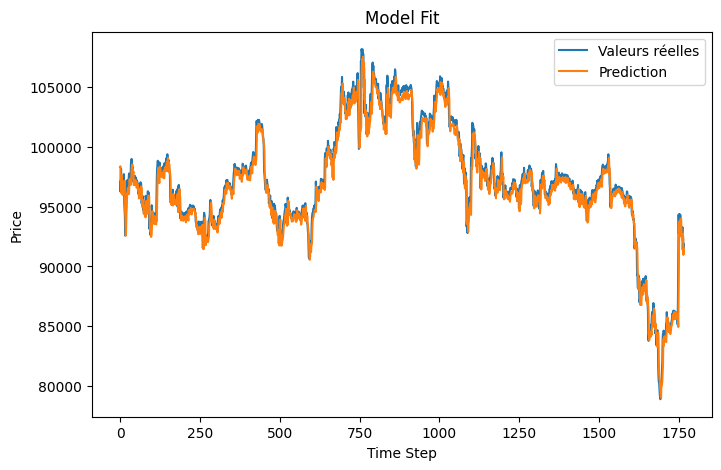

In [26]:
# Prédiction sur les données de test
predictions = history.model.predict(X_test)
predictions = scaler_target.inverse_transform(predictions)  # Inverser la normalisation

# Comparaison des prédictions avec les vraies valeurs
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(y_test_actual,label = "Valeurs réelles")
plt.plot(predictions,label="Prediction")
plt.legend()
plt.show()

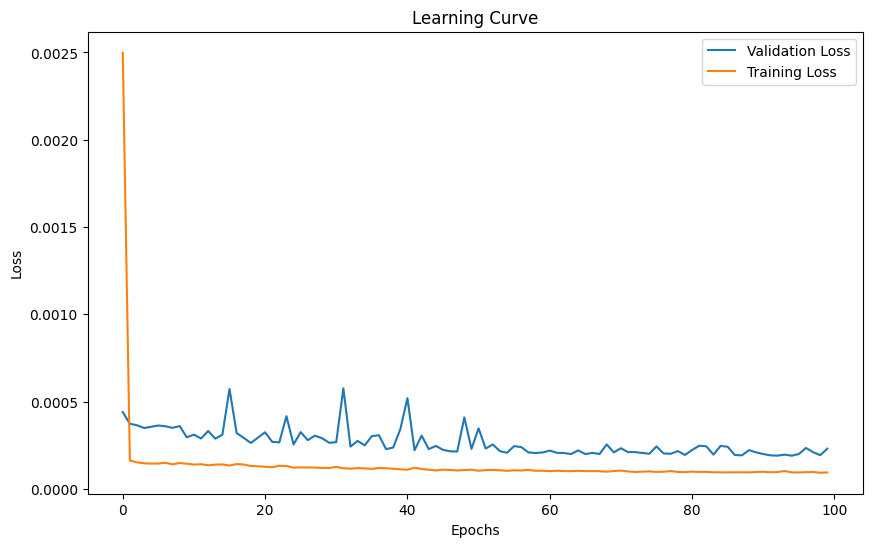

In [27]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Metriques d'évaluation

In [40]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# R2
print('RSquared : ', '{:.2%}'.format(r2_score(y_test_actual, predictions)))

Mean Squared Error: 786671.1136026696
Mean Absolute Error: 638.5058571630805
Root Mean Squared Error: 886.9448199311328
RSquared :  96.67%


## Sauvegarde du model

In [ ]:
# history.model.save('./models/dev/best_model_BTCUSD.keras')
# print('Model saved!!')

Model saved!!


In [ ]:
# df[['CLOSE']].to_csv('./notebooks/inference/datasets/btc_07_03_2024_03_03_2025.csv', index=True)

## Inférence

### Prédiction de la prochaine valeur

In [29]:
# Utiliser les dernières séquences pour prédire le prochain prix
last_seq_df = df_scaled.drop(columns=['CLOSE'])
last_sequence = X[-1]
last_sequence = last_sequence.reshape((1, SEQUENCE_LENGTH, last_sequence.shape[1]))

# Prédiction
predicted_price_scaled = history.model.predict(last_sequence)
predicted_price = scaler_target.inverse_transform(predicted_price_scaled)
print(f"Le prix de clôture prédit pour l'heure suivante est : {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Le prix de clôture prédit pour l'heure suivante est : 91484.078125


### Ajout de la valeur au prochain Timeframe

In [37]:
# Optionnel : Ajouter la prédiction au dataset
next_timestamp = ts.index[-1] + pd.Timedelta(hours=1)  # Supposons des données horaires
new_row = pd.DataFrame({'CLOSE': predicted_price[0][0]}, index=[next_timestamp])
data = pd.concat([ts['CLOSE'], new_row])
data.tail()

,CLOSE
2025-03-03 07:00:00+00:00,91399.859375
2025-03-03 08:00:00+00:00,92348.125000
2025-03-03 09:00:00+00:00,91424.125000
2025-03-03 10:00:00+00:00,91861.085938
2025-03-03 11:00:00+00:00,91484.078125


# Pipeline Prediction 

In [38]:
# Base df 
base_df = dc(new_ts)
prev_ts = base_df[['CLOSE']]

for _ in range(5):
    t_scal, enc_df = processing_before_prediction(prev_ts, SHIFT_SIZE, SEQUENCE_LENGTH, calculate_ema, 
                                                  calculate_rsi, calculate_bollinger_bands, calculate_macd )
    
    # Get the last sequence of the dataframe
    last_prev_lines = enc_df[-1]

    # Predict the next tf value
    next_index = prev_ts.index[-1] + pd.Timedelta(hours=1)
    new_line_df = predict_the_next_tf('CLOSE', 
                            last_prev_lines, 
                            lstm_model, 
                            t_scal, 
                            SEQUENCE_LENGTH, 
                            next_index)
    prev_ts = pd.concat([prev_ts, new_line_df])
    
prev_ts.tail(8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


,CLOSE
2025-03-03 08:00:00+00:00,92348.125000
2025-03-03 09:00:00+00:00,91424.125000
2025-03-03 10:00:00+00:00,91861.085938
2025-03-03 11:00:00+00:00,91484.078125
2025-03-03 12:00:00+00:00,91001.296875
2025-03-03 13:00:00+00:00,91203.218750
2025-03-03 14:00:00+00:00,90942.812500
2025-03-03 15:00:00+00:00,90570.718750


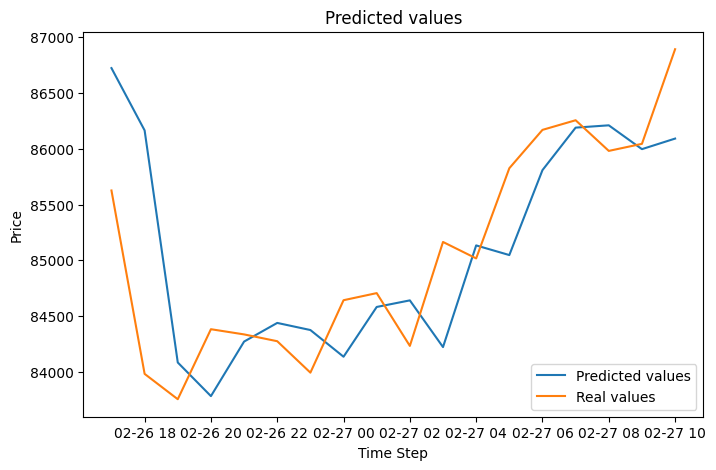

In [39]:

# Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.plot(prev_ts[['CLOSE']].loc['2025-02-26 17:00:00+00:00':'2025-02-27 10:00:00+00:00'], label='Predicted values')
plt.plot(df[['OPEN']].loc['2025-02-26 17:00:00+00:00':'2025-02-27 10:00:00+00:00'], label='Real values')
plt.title('Predicted values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
# df[['OPEN']].loc['2025-02-26 17:00:00+00:00':'2025-02-27 10:00:00+00:00']